# Batch Normalization

In this notebook, you will implement the batch normalization layers of a neural network to increase its performance.  Please review the details of batch normalization from the lecture notes.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Batchnorm forward pass

Implement the training time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ 15.87981572 -23.84655697  11.43439642]
  stds:  [30.40516277 32.58753992 30.72538153]
After batch normalization (gamma=1, beta=0)
  mean:  [ 2.12052598e-16 -5.21804822e-17  1.58761893e-16]
  std:  [0.99999999 1.         0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999998]


Implement the testing time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [4]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in np.arange(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.01760218  0.00973662 -0.00549262]
  stds:  [0.96818812 0.91391627 1.05417013]


## Batchnorm backward pass

Implement the backward pass for the batchnorm layer, `batchnorm_backward` in `nndl/layers.py`.  Check your implementation by running the following cell.

In [5]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.8327568194162306e-07
dgamma error:  6.300392459875844e-12
dbeta error:  3.531113676706066e-11


## Implement a fully connected neural network with batchnorm layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate batchnorm layers.  You will need to modify the class in the following areas:

(1) The gammas and betas need to be initialized to 1's and 0's respectively in `__init__`.

(2) The `batchnorm_forward` layer needs to be inserted between each affine and relu layer (except in the output layer) in a forward pass computation in `loss`.  You may find it helpful to write an `affine_batchnorm_relu()` layer in `nndl/layer_utils.py` although this is not necessary.

(3) The `batchnorm_backward` layer has to be appropriately inserted when calculating gradients.

After you have done the appropriate modifications, check your implementation by running the following cell.

Note, while the relative error for W3 should be small, as we backprop gradients more, you may find the relative error increases.  Our relative error for W1 is on the order of 1e-4.

In [6]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64,
                              use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    if reg == 0: print('\n')

Running check with reg =  0
Initial loss:  2.1907078229618646
W1 relative error: 0.0002119846604977984
W2 relative error: 1.8210121722282865e-06
W3 relative error: 3.3502847501659e-10
b1 relative error: 6.938893903907228e-10
b2 relative error: 1.1102230246251565e-08
b3 relative error: 1.0103078589548768e-10
beta1 relative error: 2.928549689166633e-09
beta2 relative error: 2.006695292870874e-09
gamma1 relative error: 7.307745753247095e-09
gamma2 relative error: 2.6896029886455957e-09


Running check with reg =  3.14
Initial loss:  6.8265603307418985
W1 relative error: 0.0001571164345148992
W2 relative error: 9.610496010416964e-05
W3 relative error: 3.2751037201837177e-09
b1 relative error: 7.105427357601002e-07
b2 relative error: 8.881784197001252e-08
b3 relative error: 1.5558284435353966e-10
beta1 relative error: 3.98861026284362e-06
beta2 relative error: 1.6884792633653935e-08
gamma1 relative error: 3.900747177363378e-06
gamma2 relative error: 1.0251160822317742e-08


## Training a deep fully connected network with batch normalization.

To see if batchnorm helps, let's train a deep neural network with and without batch normalization.

In [9]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.362241
(Epoch 0 / 10) train acc: 0.136000; val_acc: 0.121000
(Epoch 1 / 10) train acc: 0.377000; val_acc: 0.306000
(Epoch 2 / 10) train acc: 0.471000; val_acc: 0.319000
(Epoch 3 / 10) train acc: 0.517000; val_acc: 0.328000
(Epoch 4 / 10) train acc: 0.579000; val_acc: 0.332000
(Epoch 5 / 10) train acc: 0.628000; val_acc: 0.329000
(Epoch 6 / 10) train acc: 0.651000; val_acc: 0.344000
(Epoch 7 / 10) train acc: 0.715000; val_acc: 0.344000
(Epoch 8 / 10) train acc: 0.751000; val_acc: 0.328000
(Epoch 9 / 10) train acc: 0.788000; val_acc: 0.343000
(Epoch 10 / 10) train acc: 0.797000; val_acc: 0.307000
(Iteration 1 / 200) loss: 2.301788
(Epoch 0 / 10) train acc: 0.135000; val_acc: 0.117000
(Epoch 1 / 10) train acc: 0.233000; val_acc: 0.213000
(Epoch 2 / 10) train acc: 0.292000; val_acc: 0.283000
(Epoch 3 / 10) train acc: 0.328000; val_acc: 0.267000
(Epoch 4 / 10) train acc: 0.340000; val_acc: 0.274000
(Epoch 5 / 10) train acc: 0.344000; val_acc: 0.246000
(Epoch 6 / 

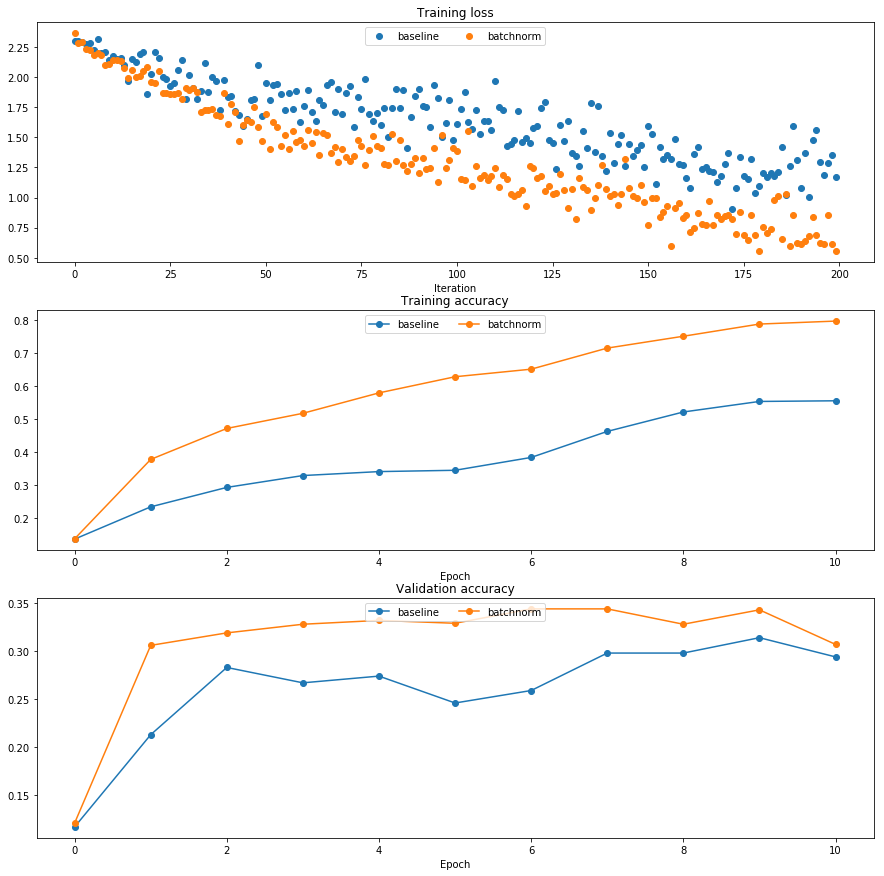

In [10]:
fig, axes = plt.subplots(3, 1)

ax = axes[0]
ax.set_title('Training loss')
ax.set_xlabel('Iteration')

ax = axes[1]
ax.set_title('Training accuracy')
ax.set_xlabel('Epoch')

ax = axes[2]
ax.set_title('Validation accuracy')
ax.set_xlabel('Epoch')

ax = axes[0]
ax.plot(solver.loss_history, 'o', label='baseline')
ax.plot(bn_solver.loss_history, 'o', label='batchnorm')

ax = axes[1]
ax.plot(solver.train_acc_history, '-o', label='baseline')
ax.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

ax = axes[2]
ax.plot(solver.val_acc_history, '-o', label='baseline')
ax.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
    ax = axes[i - 1]
    ax.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batchnorm and initialization

The following cells run an experiment where for a deep network, the initialization is varied.  We do training for when batchnorm layers are and are not included.

In [11]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale {} / {}'.format(i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


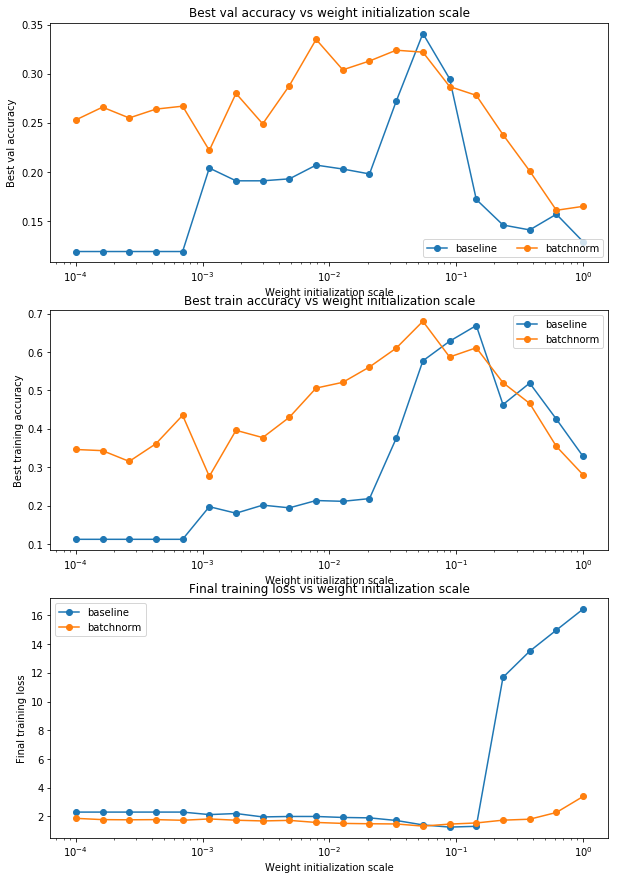

In [12]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
    
    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
    
    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

## Question:

In the cell below, summarize the findings of this experiment, and WHY these results make sense.

## Answer:
At first glance to graphs, it can be asily understood that when we use batch norm irrespective of weight initialization we are getting similar validation and training accuracy results. Except the case where we make weights too large. In other words as we make weight initialization bigger even the batch norm avoid ending up with good accuracy. We can say that without batch normalization our network heavily depend on the weight initialization.Without batch norm, according to weight initialization we can end up with no learning at all. With optimum weight initialization both base and batchnorm network give same results.So the key point here if we use batchnorm we do not need to worry about the weight initialization. This result is mainly because when we use batch norm we make sure that every layer get inputs with unit variance. This removes the dependency to weight initialization. This is important since we are using reLu function, we want our units to be active. This heavily depend on the inputs of the layers. So weight intiliazation has a huge effect if we do not use batch norm. The best accuracy values for validation and train occurs in similar regions. This accuracy is farther apart from values reached with base neural network and different weight initialization. So we can conclude that base neural network requires parameter tuning to reach a good accuracy. When we look at the loss function we can conclude that loss value is also big for the base neural network. In other words it heavily depends on weight initialization. However for batch norm it is not the case. We can also observe that when we increase the weight initialization base network becomes more susceptible whether it is not the case for batchnorm network. Batchnorm network loss does not explode. To conclude batchnorm network accuracies does not flucutuate a lot, it is smoother.


In [ ]:
import numpy as np

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

"""
This file implements various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    v=np.dot(config['momentum'],v)-np.dot(config['learning_rate'],dw)
    next_w=w+v
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def sgd_nesterov_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with Nesterov momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    temp=v
    v=config['momentum']*temp-config['learning_rate']*dw
    next_w=w+v+config['momentum']*(v-temp)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared gradient
    values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - beta: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('decay_rate', 0.99)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('a', np.zeros_like(w))

    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement RMSProp.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, so they can be used for future gradients. Concretely,
    #   config['a'] corresponds to "a" in the lecture notes.
    # ================================================================ #
    config['a']=config['decay_rate']*config['a']+(1-config['decay_rate'])*dw*dw
    next_w=w-(config['learning_rate']/(np.sqrt(config['a'])+config['epsilon']))*dw
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config


def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('a', np.zeros_like(w))
    config.setdefault('t', 0)
    
    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement Adam.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, and in config['v'] the moving average of the
    #   first moments.  Finally, store in config['t'] the increasing time.
    # ================================================================ #
    t=config['t']
    t+=1
    v=config['v']
    a=config['a']
    beta1=config['beta1']
    beta2=config['beta2']
    eps=config['learning_rate']
    nu=config['epsilon']
    
    
    v=beta1*v+(1-beta1)*dw
    a=beta2*a+(1-beta2)*dw*dw
    v_1=(v/(1-beta1**t))
    a_1=(a/(1-beta2**t))
    
    
    next_w=w-(eps/(np.sqrt(a_1)+nu))*v_1
    config['a']=a
    config['v']=v
    config['t']=t
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config


In [ ]:
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    out=x*(x>0)
    cache = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    dx=np.ones(x.shape)*(x>0)
    dx=dx*dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #
        temp_x=x
        sample_mean=np.mean(x,axis=0)
        sample_var=np.var(x,axis=0)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        a=(x-sample_mean)
        e=sample_var+eps
        c=np.sqrt(e)
        b=1/c
        x_hat=a*b
        x=(x-sample_mean)/np.sqrt(sample_var+eps)
        x=x*gamma+beta
        out=x
        cache=a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,temp_x
        pass

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        x=(x-running_mean)/np.sqrt(running_var+eps)
        x=x*gamma+beta
        out=x
        pass
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,x=cache
    dbeta=dout.sum(axis=0)
    dgamma=(dout*x_hat).sum(axis=0)
    dx_hat=dout*gamma
    da=(1/np.sqrt(sample_var+eps))*dx_hat
    db=(x-sample_mean)*dx_hat
    dc=(-1/(sample_var+eps))*db
    de=0.5*((1/np.sqrt(sample_var+eps)))*dc
    dvar=de.sum(axis=0)
    dmu=-da.sum(axis=0)-dvar*(2/x.shape[0])*((x-sample_mean).sum(axis=0))
    dx=(1/np.sqrt(sample_var+eps))*dx_hat+(2*(x-sample_mean)/x.shape[0])*dvar+dmu/x.shape[0]
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask=(np.random.rand(*x.shape)<p)/p
        x=mask*x
        out=x
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        
        out=x
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        dx=mask*dout
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        
        dx=dout
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx



In [ ]:
import numpy as np
import pdb

from .layers import *
from .layer_utils import *

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.
    
    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    
    def __init__(self, input_dim=3*32*32, hidden_dims=100, num_classes=10,
                 dropout=0, weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dims: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Initialize W1, W2, b1, and b2.  Store these as self.params['W1'], 
        #   self.params['W2'], self.params['b1'] and self.params['b2']. The
        #   biases are initialized to zero and the weights are initialized
        #   so that each parameter has mean 0 and standard deviation weight_scale.
        #   The dimensions of W1 should be (input_dim, hidden_dim) and the
        #   dimensions of W2 should be (hidden_dims, num_classes)
        # ================================================================ #


        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """  
        scores = None

        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the forward pass of the two-layer neural network. Store
        #   the class scores as the variable 'scores'.  Be sure to use the layers
        #   you prior implemented.
        # ================================================================ #    
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores
        
        loss, grads = 0, {}
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the backward pass of the two-layer neural net.  Store
        #   the loss as the variable 'loss' and store the gradients in the 
        #   'grads' dictionary.  For the grads dictionary, grads['W1'] holds
        #   the gradient for W1, grads['b1'] holds the gradient for b1, etc.
        #   i.e., grads[k] holds the gradient for self.params[k].
        #
        #   Add L2 regularization, where there is an added cost 0.5*self.reg*W^2
        #   for each W.  Be sure to include the 0.5 multiplying factor to 
        #   match our implementation.
        #
        #   And be sure to use the layers you prior implemented.
        # ================================================================ #    
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        
        return loss, grads


class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.hidden_dims=hidden_dims
    self.params = {}

    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    # ================================================================ #
    
    self.params['W'+str(1)]=weight_scale*np.random.randn(input_dim,hidden_dims[0])
    self.params['b'+str(1)]=np.zeros(hidden_dims[0])
    self.params['W'+str(len(hidden_dims)+1)]=weight_scale*np.random.randn(hidden_dims[len(hidden_dims)-1],num_classes)
    self.params['b'+str(len(hidden_dims)+1)]=np.zeros(num_classes)
    if(use_batchnorm):
            self.params['gamma'+str(1)]=np.ones(hidden_dims[0])
            self.params['beta'+str(1)]=np.zeros(hidden_dims[0])
    for i in range(len(hidden_dims)-1):
            self.params['W'+str(i+2)]=weight_scale*np.random.randn(hidden_dims[i],hidden_dims[i+1])
            self.params['b'+str(i+2)]=np.zeros(hidden_dims[i+1])
            if(use_batchnorm):
                self.params['gamma'+str(i+2)]=np.ones(hidden_dims[i+1])
                self.params['beta'+str(i+2)]=np.zeros(hidden_dims[i+1])
        
    
    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    # ================================================================ #
    diccache = {}
    diccacherel={}
    diccachebatch={}
    dicdropcache={}
    
    out, kes=affine_forward(X,self.params['W1'],self.params['b1'])
    if(self.use_batchnorm):
        out,diccachebatch['X1']=batchnorm_forward(out, self.params['gamma'+str(1)], self.params['beta'+str(1)], self.bn_params[0])
    out,diccacherel['X1']=relu_forward(out)
    if(self.use_dropout ):
        out,dicdropcache['X1']=dropout_forward(out, self.dropout_param)
    diccache['X1']=kes
    
    #print(X.shape)
    #print(out.shape)
    #print(self.params['W2'].shape)
    temp=out
    
    for i in range (len(self.hidden_dims)-1):
        out, kes=affine_forward(temp,self.params['W'+str(i+2)],self.params['b'+str(i+2)])
        diccache['X'+str(i+2)]=kes
        if(self.use_batchnorm):
            out,diccachebatch['X'+str(i+2)]=batchnorm_forward(out, self.params['gamma'+str(i+2)], self.params['beta'+str(i+2)], self.bn_params[i+1])
        temp,kes=relu_forward(out)
        if(self.use_dropout ):
            temp,dicdropcache['X'+str(i+2)]=dropout_forward(temp,self.dropout_param)
        diccacherel['X'+str(i+2)]=kes
    out, kes=affine_forward(temp,self.params['W'+str(len(self.hidden_dims)+1)],self.params['b'+str(len(self.hidden_dims)+1)])
    diccache['X'+str(len(self.hidden_dims)+1)]=kes
    scores=out
    loss,dx=softmax_loss(out, y)
    for i in range (len(self.hidden_dims)+1):
        loss=loss+self.reg*0.5*np.sum(self.params['W'+str(i+1)]**2)
    
    #print(loss)

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = loss, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    # ================================================================ #
    dout=dx
    
    dout,grads['W'+str(len(self.hidden_dims)+1)],grads['b'+str(len(self.hidden_dims)+1)]=affine_backward(dout, diccache['X'+str(len(self.hidden_dims)+1)])
    grads['W'+str(len(self.hidden_dims)+1)]=grads['W'+str(len(self.hidden_dims)+1)]+self.reg*self.params['W'+str(len(self.hidden_dims)+1)]
    #grads['W'+len(self.hidden_dims)+1]=dx
    for i in range(len(self.hidden_dims),1,-1):
        if (self.use_batchnorm):
            #dout=dropout_backward(dout, dicdropcache['X'+str(i)])
            dout=relu_backward(dout, diccacherel['X'+str(i)])
            dout, grads['gamma'+str(i)], grads['beta'+str(i)]=batchnorm_backward(dout,diccachebatch['X'+str(i)])
            dout,grads['W'+str(i)],grads['b'+str(i)]=affine_backward(dout, diccache['X'+str(i)])
            grads['W'+str(i)]=grads['W'+str(i)]+self.reg*self.params['W'+str(i)]
            
        else:
            if(self.use_dropout ):
                dout=dropout_backward(dout, dicdropcache['X'+str(i)])
            dout=relu_backward(dout, diccacherel['X'+str(i)])
            dout,grads['W'+str(i)],grads['b'+str(i)]=affine_backward(dout, diccache['X'+str(i)])
            grads['W'+str(i)]=grads['W'+str(i)]+self.reg*self.params['W'+str(i)]
    if (self.use_batchnorm):
        #dout=dropout_backward(dout, dicdropcache['X1'])
        dout=relu_backward(dout, diccacherel['X1'])
        dout, grads['gamma1'], grads['beta1']=batchnorm_backward(dout,diccachebatch['X1'])
        dout,grads['W1'],grads['b1']=affine_backward(dout, diccache['X1']) 
        grads['W1']=grads['W1']+self.reg*self.params['W1']
        
    else:
        if(self.use_dropout ):
            dout=dropout_backward(dout, dicdropcache['X1'])
        dout=relu_backward(dout, diccacherel['X1'])
        dout,grads['W1'],grads['b1']=affine_backward(dout, diccache['X1']) 
        grads['W1']=grads['W1']+self.reg*self.params['W1']
        

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    return loss, grads
################################################################
    ###############################
    ############################
    ##############
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    out=x*(x>0)
    cache = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    dx=np.ones(x.shape)*(x>0)
    dx=dx*dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #
        temp_x=x
        sample_mean=np.mean(x,axis=0)
        sample_var=np.var(x,axis=0)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        a=(x-sample_mean)
        e=sample_var+eps
        c=np.sqrt(e)
        b=1/c
        x_hat=a*b
        x=(x-sample_mean)/np.sqrt(sample_var+eps)
        x=x*gamma+beta
        out=x
        cache=x_hat,gamma,sample_var,sample_mean,eps,temp_x
        pass

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        x=(x-running_mean)/np.sqrt(running_var+eps)
        x=x*gamma+beta
        out=x
        pass
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    x_hat,gamma,sample_var,sample_mean,eps,x=cache
    dbeta=dout.sum(axis=0)
    dgamma=(dout*x_hat).sum(axis=0)
    dx_hat=dout*gamma
    da=(1/np.sqrt(sample_var+eps))*dx_hat
    db=(x-sample_mean)*dx_hat
    dc=(-1/(sample_var+eps))*db
    de=0.5*((1/np.sqrt(sample_var+eps)))*dc
    dvar=de.sum(axis=0)
    dmu=-da.sum(axis=0)-dvar*(2/x.shape[0])*((x-sample_mean).sum(axis=0))
    dx=(1/np.sqrt(sample_var+eps))*dx_hat+(2*(x-sample_mean)/x.shape[0])*dvar+dmu/x.shape[0]
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask=(np.random.rand(*x.shape)<p)/p
        x=mask*x
        out=x
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        out=x
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        
        dx=mask*dout
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        dx=dout
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    probs[probs<1e-10]=1e-10
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

